# Estratégia 1: Creación de Producto Artificial
En este Notebook Vamos a Generar un nuevo producto con venta 3 veces superior al producto Estrella con la intención de evitar la caída en la predicción del Estrella.

## Importamos librerías

In [1]:
###### Feature Engineering ######
import pandas as pd
import numpy as np
from window_ops.rolling import rolling_mean, rolling_max, rolling_min

###### Load the API  ######
import requests
import gzip
import io

###### Forecasting ######
from mlforecast import MLForecast
from empresa4.core import calculate_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import lightgbm as lgb 


from empresa4.datasets import nombres_datasets, get_dataset

###### Visualize ######
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# Set the display.max_columns to None to display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Imprime la lista de nombres de datasets
for nombre in nombres_datasets:
    print(nombre)

01_original
01_producto_estrella
01_productos_todos
01_por_cliente
maestro_productos


## Funciones

In [2]:
def cargar_dataset(url, sep='\t', header='infer'):
    """
    Lee un archivo CSV comprimido con gzip desde una URL y lo carga en un DataFrame de Pandas.

    :param url: String con la URL del archivo .gz.
    :param sep: String delimitador para separar campos en el archivo CSV.
    :param header: Parámetro para determinar la fila que debe usarse como nombre de las columnas.
    :return: DataFrame de Pandas con los datos del archivo CSV.
    """
    # Realizar la petición HTTP para obtener el contenido del archivo
    response = requests.get(url)

    # Asegurarse de que la petición fue exitosa
    if response.status_code == 200:
        # Descomprimir el contenido en memoria y leer directamente en un DataFrame
        with io.BytesIO(response.content) as bytes_io:
            with gzip.open(bytes_io, 'rt') as read_file:
                df = pd.read_csv(read_file, sep=sep, header=header)
        return df
    else:
        raise IOError(f"Error al descargar el archivo: {response.status_code}")
    
def read_csv_from_url(url, sep='\t', header='infer'):
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep=sep, header=header)
        return df
    else:
        raise IOError(f"Error al descargar el archivo: {response.status_code}")
    
def plotear_grafico(df):
    # Convertir el 'periodo' a formato de fecha para mejor visualización en el gráfico
    df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

    # Crear nuevamente el gráfico de línea con Seaborn
    plt.figure(figsize=(14, 7))
    line_plot = sns.lineplot(data=df, x='periodo', y='tn', marker='o', color='blue', linewidth=2.5)

    # Títulos y etiquetas
    line_plot.set_title('Evolución de Toneladas a lo largo del Tiempo', fontsize=16)
    line_plot.set_xlabel('Periodo', fontsize=14)
    line_plot.set_ylabel('Toneladas (tn)', fontsize=14)

    # Establecer el formato del eje x para mostrar todos los periodos
    line_plot.xaxis.set_major_locator(plt.MaxNLocator(len(df['periodo'])))
    line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    
def fill_missing_months_multi_product(df):
    # Find the earliest and latest period (assuming the format is YYYYMM)
    min_year = df['periodo'].min() // 100
    max_year = df['periodo'].max() // 100

    # Generate all combinations of year and months
    all_periods = pd.DataFrame({
        'periodo': [year * 100 + month for year in range(min_year, max_year + 1) for month in range(1, 13)]
    })

    product_ids = df['product_id'].unique()
    all_period_product_combinations = (
        all_periods.assign(key=1)
        .merge(pd.DataFrame({'product_id': product_ids, 'key': 1}), on='key')
        .drop(columns=['key'])  # Using the 'columns' parameter for clarity
    )

    # Merge with the original DataFrame
    df_complete = all_period_product_combinations.merge(df, on=['periodo', 'product_id'], how='left')

    # Fill the 'tn' column with zeros where there are NaNs
    df_complete['tn'] = df_complete['tn'].fillna(0)

    # Forward fill or backfill other columns that don't change for each product
    columns_to_fill = ['plan_precios_cuidados', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size']
    df_complete.sort_values(by=['product_id', 'periodo'], inplace=True)
    df_complete[columns_to_fill] = df_complete.groupby('product_id')[columns_to_fill].ffill().bfill()
    return df_complete

def generar_delta_lags_optimizado(df, prefijo_lag='lag_', prefijo_delta_lag='delta_lag_'):
    """
    Genera delta lags de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original que ya contiene las columnas de lags.
    :param prefijo_lag: Prefijo utilizado para las columnas de lags en el DataFrame.
    :param prefijo_delta_lag: Prefijo utilizado para las nuevas columnas de delta lags.
    :return: DataFrame con las columnas de delta lags añadidas.
    """
    
    # Identificar todas las columnas de lags en el DataFrame
    columnas_lags = [col for col in df.columns if col.startswith(prefijo_lag)]
    
    # Generar las columnas de delta lags
    for i in range(len(columnas_lags) - 1):
        col_lag_actual = columnas_lags[i]
        col_lag_siguiente = columnas_lags[i + 1]
        df[prefijo_delta_lag + str(i + 1)] = df[col_lag_actual] - df[col_lag_siguiente]
    
    return df

# Re-creating the optimized lag generation function after the reset
def generar_lags_optimizado(df, nombre_col_original='tn', cant_lags=12):
    """
    Genera lags de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original.
    :param nombre_col_original: Nombre de la columna sobre la cual se quieren calcular los lags.
    :param cant_lags: Cantidad de lags a generar.
    :return: DataFrame con las columnas de lags añadidas.
    """
    
    # Obtener una lista de productos únicos
    productos_unicos = df['product_id'].unique()
    
    # Preparar un contenedor para los DataFrames de lags
    lags_list = []
    
    # Iterar sobre cada producto único
    for producto in productos_unicos:
        # Filtrar el DataFrame por producto
        df_producto = df[df['product_id'] == producto].copy()
        
        # Generar lags para la columna deseada
        for lag in range(1, cant_lags + 1):
            df_producto[f'lag_{lag}'] = df_producto[nombre_col_original].shift(lag)
        
        # Añadir el DataFrame de lags a la lista
        lags_list.append(df_producto)
    
    # Concatenar todos los DataFrames de lags
    df_con_lags = pd.concat(lags_list).sort_index()
    
    return df_con_lags

def generar_medias_optimizado(df, nombre_col_original='tn', lista_medias_target=[2,3,4,6,10], prefijo_col_media='media'):
    """
    Genera las medias móviles de los últimos N meses de manera más eficiente para una columna específica de un DataFrame de pandas.

    :param df: DataFrame original.
    :param nombre_col_original: Nombre de la columna sobre la cual se quieren calcular las medias móviles.
    :param lista_medias_target: Lista de enteros que representan el número de meses para calcular la media móvil.
    :param prefijo_col_media: Prefijo para las nuevas columnas de medias móviles.
    :return: DataFrame con las columnas de medias móviles añadidas.
    """
    
    # Obtener una lista de productos únicos
    productos_unicos = df['product_id'].unique()
    
    # Preparar un contenedor para los DataFrames de medias móviles
    medias_list = []
    
    # Iterar sobre cada producto único
    for producto in productos_unicos:
        # Filtrar el DataFrame por producto
        df_producto = df[df['product_id'] == producto].copy()
        
        # Generar medias móviles para cada ventana especificada en lista_medias_target
        for ventana in lista_medias_target:
            col_media = f'{nombre_col_original}_{prefijo_col_media}_{ventana}'
            df_producto[col_media] = df_producto[nombre_col_original].rolling(window=ventana).mean().shift()
        
        # Añadir el DataFrame de medias móviles a la lista
        medias_list.append(df_producto)
    
    # Concatenar todos los DataFrames de medias móviles
    df_con_medias = pd.concat(medias_list).sort_index()
    
    return df_con_medias

# Custom transformer for label encoding multiple columns
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}
    
    def fit(self, X, y=None):
        for column in X.columns:
            self.encoders[column] = LabelEncoder().fit(X[column])
        return self
    
    def transform(self, X):
        X_encoded = X.copy()
        for column in X.columns:
            X_encoded[column] = self.encoders[column].transform(X[column])
        return X_encoded
    
    def inverse_transform(self, X):
        X_decoded = X.copy()
        for column in X.columns:
            X_decoded[column] = self.encoders[column].inverse_transform(X[column])
        return X_decoded

## Importamos Datasets

In [3]:
# URL del archivo .gz
url_tb_sellout_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_sellout_02.txt.gz'
url_tb_stocks_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_stocks_02.txt.gz'
url_tb_productos_02 = 'https://storage.googleapis.com/open-courses/austral2023-labo3-d0e5/tb_productos_02.txt'

# Uso de la función
df_tb_sellout_02 = cargar_dataset(url_tb_sellout_02)
df_tb_stocks_02 = cargar_dataset(url_tb_stocks_02)
df_tb_productos_02= read_csv_from_url(url_tb_productos_02)

In [4]:
# Productos distintos
df_tb_productos_02.product_id.drop_duplicates().count()

1251

## Pre Processing

In [5]:
# Juntamos los datasets Sellout con el maestro de productos
df_sellout_with_cat = pd.merge(df_tb_sellout_02, df_tb_productos_02[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size']], on='product_id', how='left')
# Agrupamos por categorías de productos
df_aggregated = df_sellout_with_cat.groupby(['periodo', 'product_id', 'plan_precios_cuidados', 
                                             'cat1', 'cat2', 'cat3', 'brand', 'sku_size']).agg({'cust_request_tn': 'sum','tn': 'sum'}).reset_index()

## Análisis Exploratorio

C:\Users\Lean\AppData\Local\Temp\ipykernel_3660\1577208087.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 29261 ticks ([17113.800000000003, ..., 18284.2]), which exceeds Locator.MAXTICKS (1000

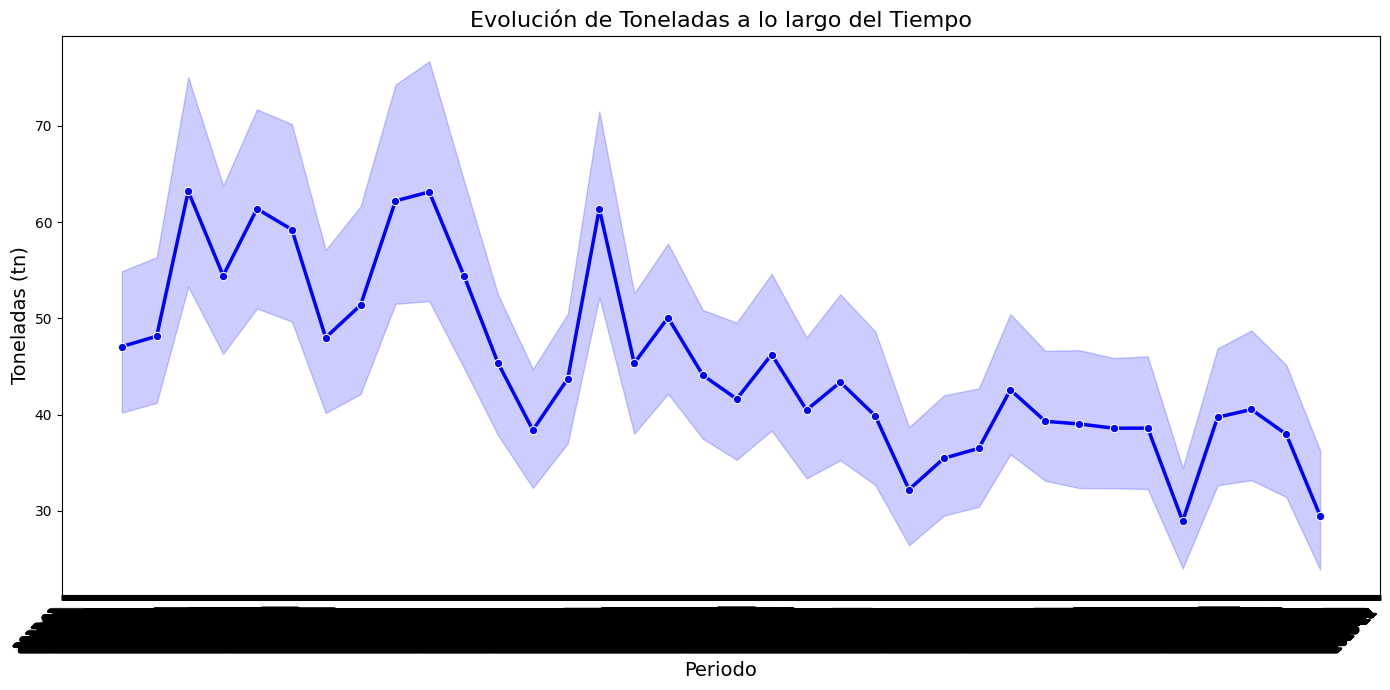

In [39]:
# Producto Estrella
plotear_grafico(df_aggregated)

C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')


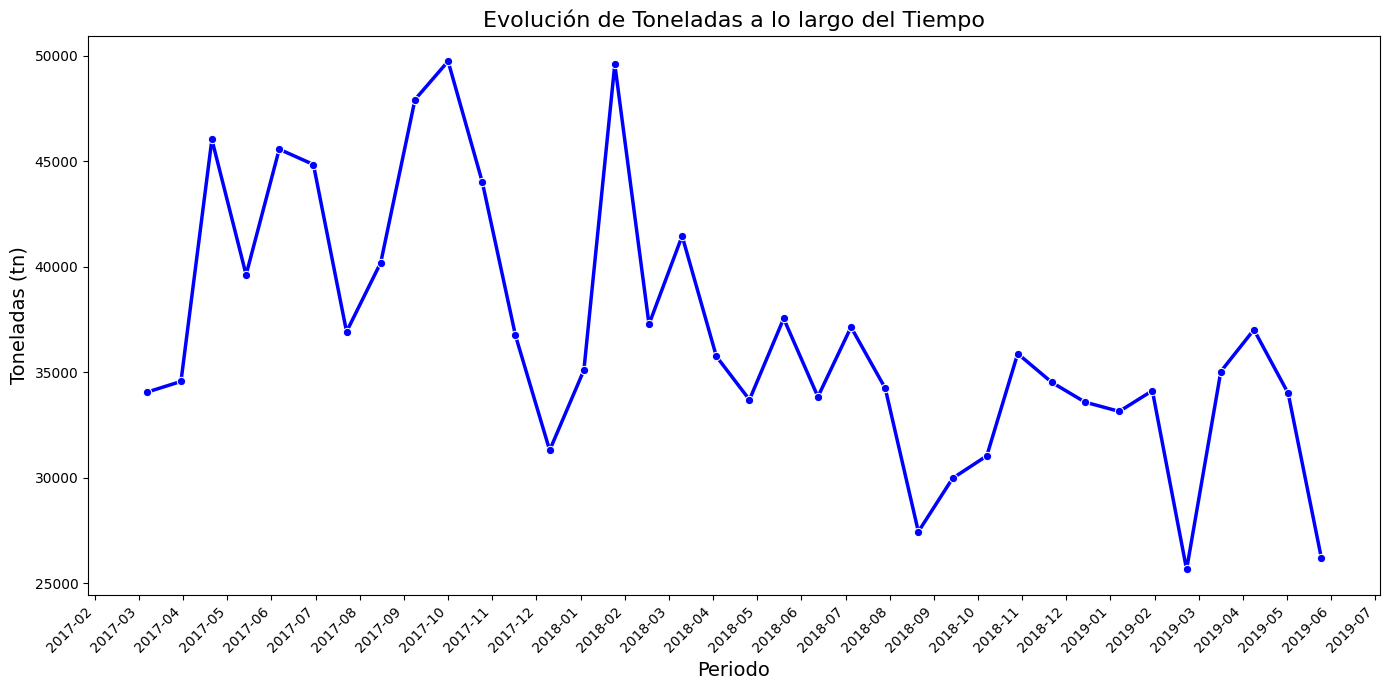

In [10]:
# Todos los productos
plotear_grafico(df_productos_grouped)

C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')


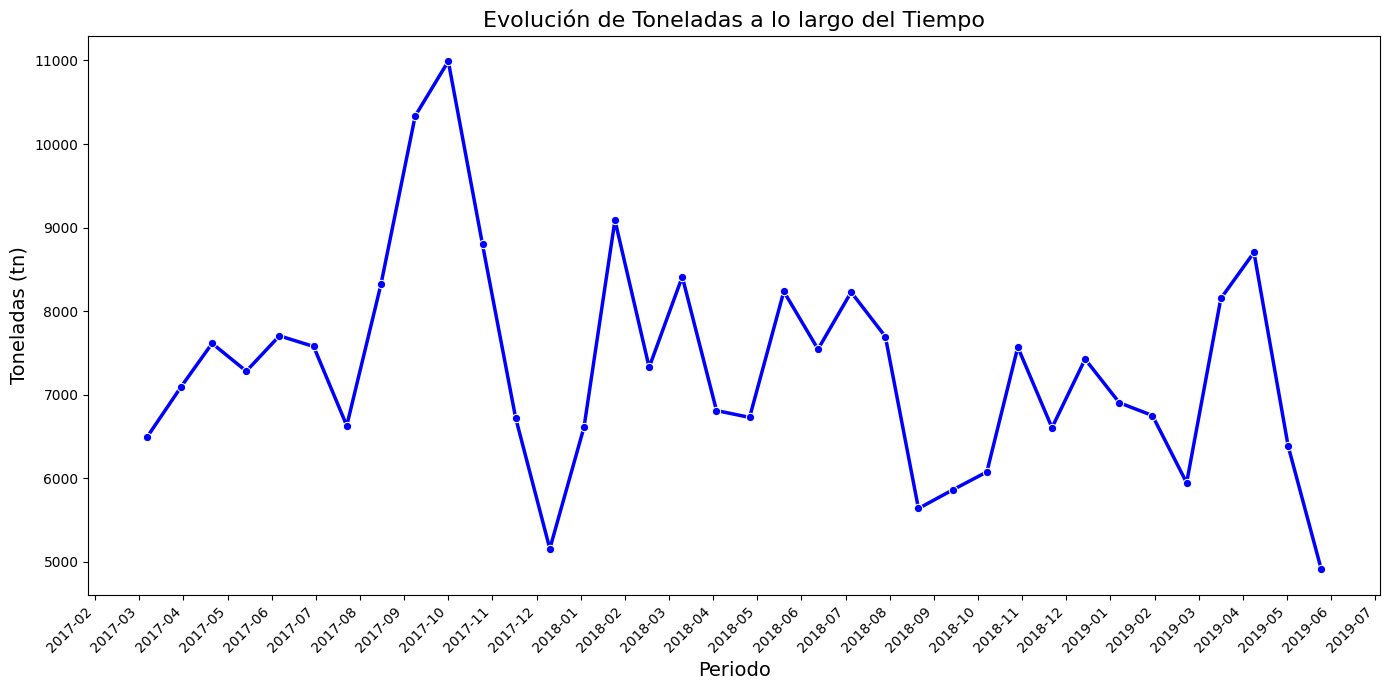

In [13]:
# Todos los productos de FOODS
plotear_grafico(df_productos_cat_foods)

In [ ]:
df_productos_cat_ref = df_productos_cat_grouped[df_productos_cat_grouped.product_category=='REF']

C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')


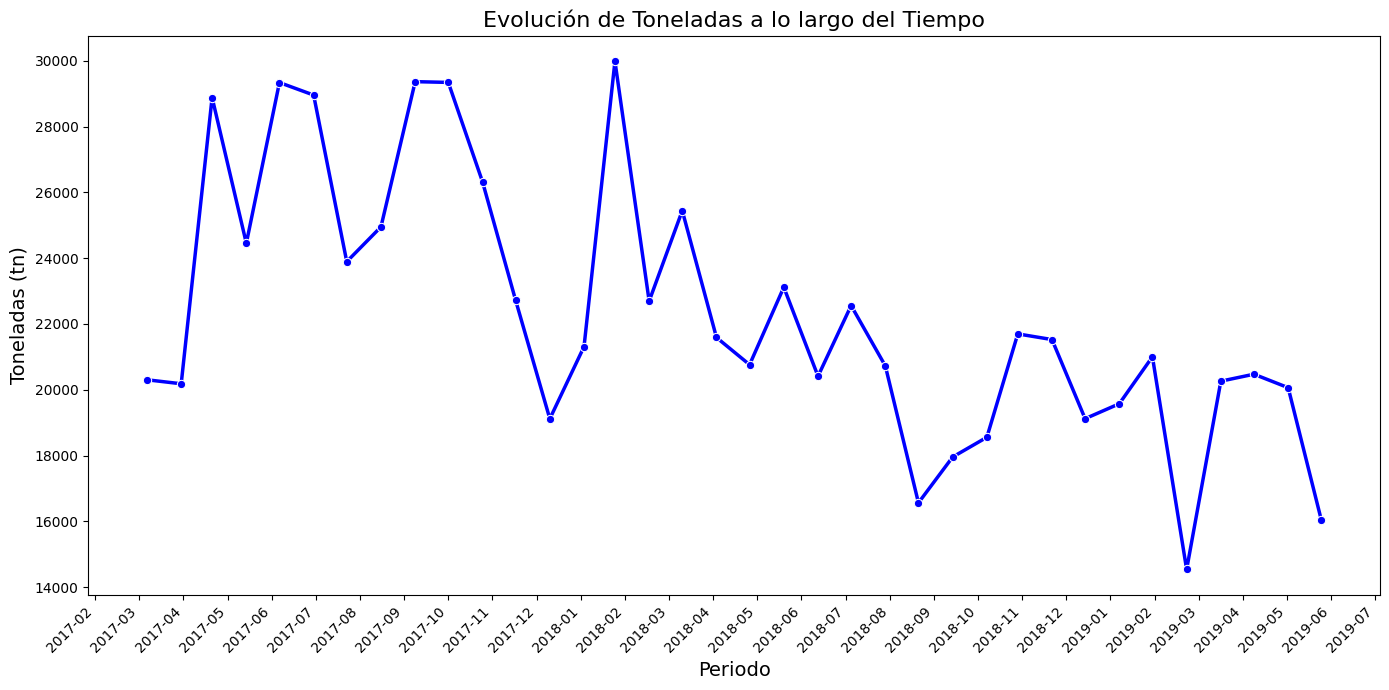

In [15]:
# Todos los productos de HC
plotear_grafico(df_productos_cat_hc)

C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')


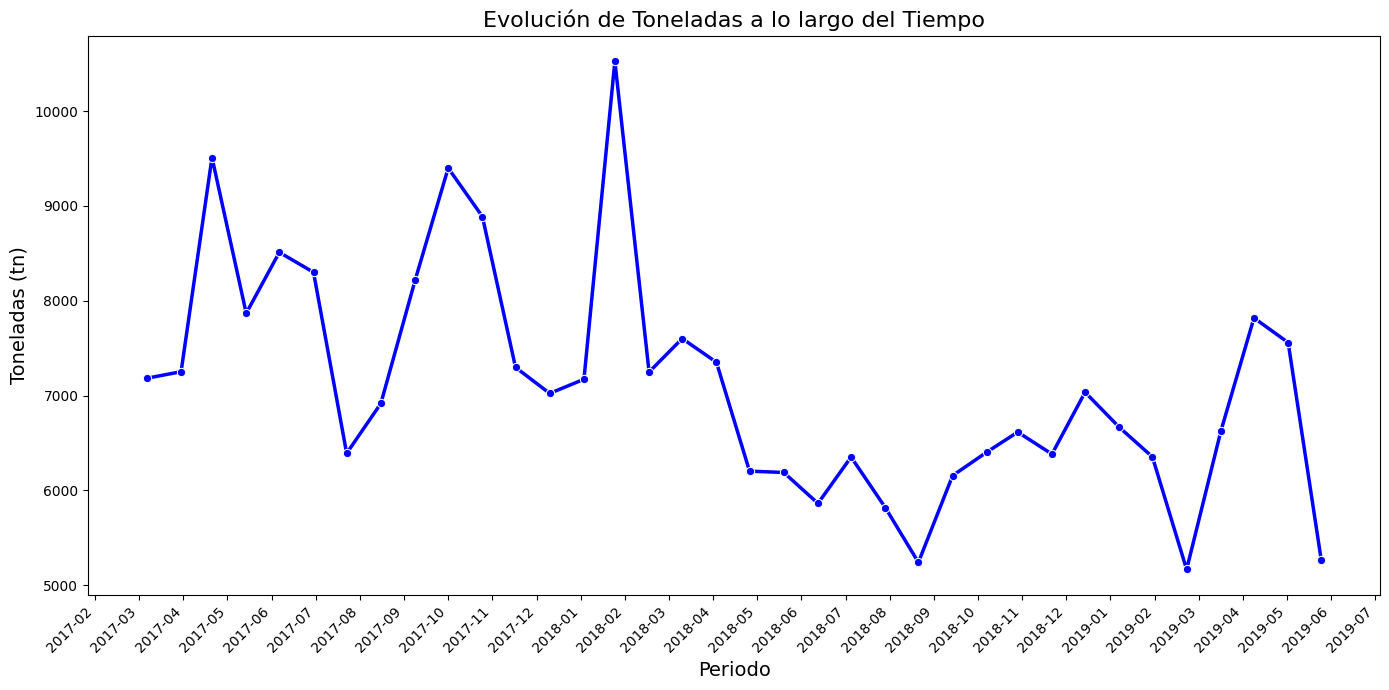

In [16]:
# Todos los productos de PC
plotear_grafico(df_productos_cat_pc)

C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')
C:\Users\Lean\AppData\Local\Temp\ipykernel_22264\2503096694.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  line_plot.set_xticklabels(df['periodo'].dt.strftime('%Y-%m'), rotation=45, ha='right')


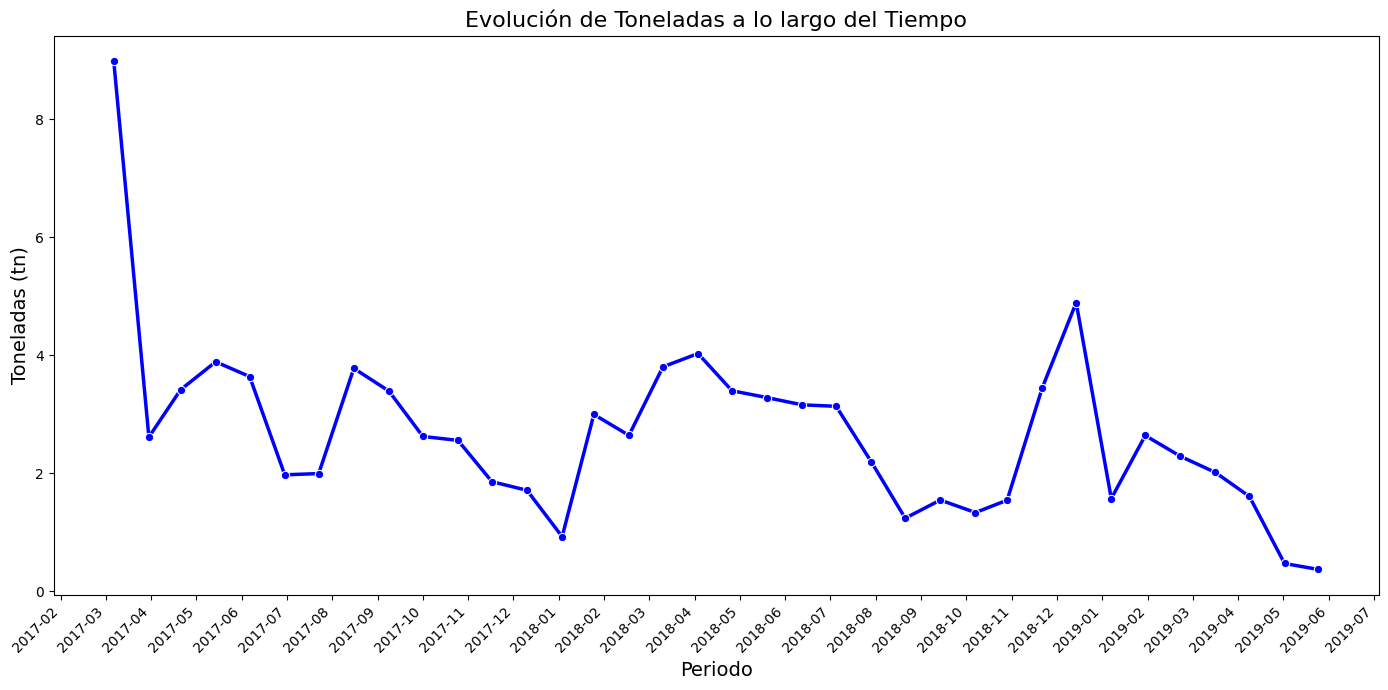

In [17]:
# Todos los productos de REF
plotear_grafico(df_productos_cat_ref)

## Feature Engineering

In [6]:
# Llamamos a la función para rellenar los registros faltantes
df_complete = fill_missing_months_multi_product(df_aggregated)

### Creamos un nuevo producto artificial con venta 3 veces la del producto Estrella

In [7]:
# Crear un nuevo DataFrame con los mismos periodos que df_complete
periodos = df_complete['periodo'].unique()  # Extraer los periodos únicos
datos_ficticios = {
    'periodo': periodos,
    'product_id': 99999,  # ID del producto ficticio
    'plan_precios_cuidados': 0.0,
    'cat1': 'HC',
    'cat2': 'Artificial',
    'cat3': 'Artificial',
    'brand': 'Producto_artificial',
    'sku_size': 3000.0,
    # Inicializamos cust_request_tn y tn con ceros, los actualizaremos luego
    'cust_request_tn': [0] * len(periodos),
    'tn': [0] * len(periodos)
}

df_ficticio = pd.DataFrame(datos_ficticios)

# Ahora, actualizamos 'cust_request_tn' y 'tn' con 10 veces los valores del producto 20001
# Asumimos que 'product_id' es único por periodo en df_complete
for periodo in periodos:
    # Encuentra los valores para el producto 20001 en el periodo actual
    valores_producto = df_complete[(df_complete['periodo'] == periodo) & (df_complete['product_id'] == 20001)]
    if not valores_producto.empty:
        df_ficticio.loc[df_ficticio['periodo'] == periodo, 'cust_request_tn'] = valores_producto['cust_request_tn'].values[0] * 3
        df_ficticio.loc[df_ficticio['periodo'] == periodo, 'tn'] = valores_producto['tn'].values[0] * 3

# Concatenar el DataFrame ficticio con el original
df_complete_con_ficticio = pd.concat([df_complete, df_ficticio], ignore_index=True)


C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\2823364550.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2813.18151' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ficticio.loc[df_ficticio['periodo'] == periodo, 'cust_request_tn'] = valores_producto['cust_request_tn'].values[0] * 3
C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\2823364550.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2804.31666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ficticio.loc[df_ficticio['periodo'] == periodo, 'tn'] = valores_producto['tn'].values[0] * 3


In [77]:
# Generamos los lags
df_complete_lags = generar_lags_optimizado(df_complete_con_ficticio)
# Utilizamos el DataFrame con lags generado anteriormente para crear los delta lags
df_complete_delta_lags = generar_delta_lags_optimizado(df_complete_lags)
# Utilizamos el DataFrame con lags generado anteriormente para crear las medias móviles
df_final = generar_medias_optimizado(df_complete_delta_lags)
df_final = df_final.fillna(0)

## Cross Validation por corte temporal

In [9]:
# Assuming df_final is the DataFrame you want to split into train and validation sets:
df_final['periodo'] = pd.to_datetime(df_final['periodo'], format='%Y%m')

# Cortamos hasta Febrero inclusive como TRAIN
train = df_final[df_final['periodo'] <= pd.to_datetime('201902', format='%Y%m')]
# Usamos MARZO como test
valid_marzo = df_final[df_final['periodo'] == pd.to_datetime('201903', format='%Y%m')]
# Usamos Abril como testing del PIPELINE
valid = df_final[df_final['periodo'] == pd.to_datetime('201903', format='%Y%m')]

# Para predecir Marzo
X_train = train.drop(columns=['tn', 'periodo'])
y_train = train['tn']
X_test = valid_marzo.drop(columns=['tn', 'periodo'])
y_test = valid_marzo['tn']

## Modeling

### LGBM

In [10]:
# Create the LightGBM dataset
categorical_features = ['cat1', 'cat2', 'cat3', 'brand']

# Convert categorical features to 'category' type

for feature in categorical_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')


train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)


# Define the parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Train the model
gbm = lgb.train(params, train_data, num_boost_round=100)

In [11]:
# Predict on the test set
y_pred_marzo = gbm.predict(X_test)

In [12]:
y_test_array = y_test.to_numpy()
error = calculate_error(y_pred_marzo, y_test_array)

# Print the error for todos los productos
print(f'The error of the forecast is: {error}')

The error of the forecast is: 0.04735653869677583


In [13]:
# Suponiendo que 'valid_marzo' es tu DataFrame y 'y_pred' es la serie de predicciones:
valid_marzo['y_pred_marzo'] = y_pred_marzo
producto_estrella_marzo = valid_marzo[valid_marzo.product_id ==20001]

error = calculate_error(list(producto_estrella_marzo.y_pred_marzo), list(producto_estrella_marzo.tn))

# Print the error for todos los productos
print(f'The error of the forecast is: {error}')

The error of the forecast is: 0.08757953705569263


C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\2003783269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_marzo['y_pred_marzo'] = y_pred_marzo


#### Incluimos las prediccioines de MARZO en el TRAIN para predecir ABRIL

In [190]:
# Actualizar el conjunto de entrenamiento
new_row = X_test.copy()
train_con_marzo = train.copy()

new_row['tn'] = y_pred_marzo  # Añade la predicción como el valor real de 'tn'
new_row['periodo'] = '2019-03-01'  # Añadir la columna 'periodo'

train_con_marzo = pd.concat([train_con_marzo, new_row]) # contiene los datos reales hasta FEB19 y agrega la prediccion de MAR19

valid_abril = df_final[['product_id','periodo','plan_precios_cuidados','cat1','cat2','cat3','brand','sku_size','cust_request_tn','tn']].copy()
# Filtramos por ABRIL
valid_abril= valid_abril[valid_abril.periodo == 201904]
# Luego, utiliza pd.to_datetime para convertir a formato de fecha, especificando el formato original
valid_abril['periodo'] = pd.to_datetime(valid_abril['periodo'], format='%Y%m')
# Finalmente, reformatea las fechas al nuevo formato deseado
valid_abril['periodo'] = valid_abril['periodo'].dt.strftime('%Y-%m-%d')
# Concatenamos MARZO con el TRAIN
df_complete_2 = pd.concat([train_con_marzo, valid_abril])

In [195]:
probando = df_complete_2[df_complete_2.product_id == 20001].tail(3)
probando[['periodo','product_id','tn','lag_1','lag_2']]

,periodo,product_id,tn,lag_1,lag_2
25,2019-02-01 00:00:00,20001,1259.093630,1275.77351,1486.68669
26,2019-03-01,20001,1599.455948,1259.09363,1275.77351
27,2019-04-01,20001,1647.638480,NaN,NaN


#### Generamos el Feature Engineering necesario

In [196]:
# Generamos los lags
df_complete_lags_2 = generar_lags_optimizado(df_complete_2)
# Utilizamos el DataFrame con lags generado anteriormente para crear los delta lags
df_complete_delta_lags_2 = generar_delta_lags_optimizado(df_complete_lags_2)
# Utilizamos el DataFrame con lags generado anteriormente para crear las medias móviles
df_final_2 = generar_medias_optimizado(df_complete_delta_lags_2)

In [197]:
probando = df_final_2[(df_final_2.product_id==20001)].tail(3)
probando[['product_id','periodo','tn','lag_1','lag_2']]

,product_id,periodo,tn,lag_1,lag_2
25,20001,2019-02-01 00:00:00,1259.093630,1275.773510,1486.68669
26,20001,2019-03-01,1599.455948,1259.093630,1275.77351
27,20001,2019-04-01,1647.638480,1599.455948,1259.09363


In [200]:
# Separamos la Data entre TRAIN y TEST
df_final_2['periodo'] = pd.to_datetime(df_final_2['periodo'], format='%Y-%m-%d')

train_abril = df_final_2[df_final_2['periodo'] <= pd.to_datetime('2019-03-01')] # Vuelvo a hacer el corte hasta MArzo con MAR19 predicho
valid_abril = df_final_2[df_final_2['periodo'] == pd.to_datetime('2019-04-01')] # vuelvo a asignar ABRIL pero esta vez con los LAGS y DELTAS

# Cross Validation por corte temporal
X_train_abril = train_abril.drop(['tn', 'periodo'], axis=1)
y_train_abril = train_abril['tn']

X_test_abril = valid_abril.drop(columns=['tn', 'periodo'])
y_test_abril = valid_abril['tn']

#### Modelamos nuevamente

In [202]:
# Create the LightGBM dataset
categorical_features = ['cat1', 'cat2', 'cat3', 'brand']

# Convert categorical features to 'category' type

for feature in categorical_features:
    X_train_abril[feature] = X_train_abril[feature].astype('category')
    X_test_abril[feature] = X_test_abril[feature].astype('category')


train_data_abril = lgb.Dataset(X_train_abril, label=y_train_abril, categorical_feature=categorical_features, free_raw_data=False)


# Define the parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Train the model
gbm = lgb.train(params, train_data_abril, num_boost_round=100)

In [203]:
# Predict on the test set
y_pred_abril = gbm.predict(X_test_abril)

In [204]:
y_test_array = y_test_abril.to_numpy()
error = calculate_error(y_pred_abril, y_test_array)

# Print the error
print(f'The error of the forecast is: {error}')

The error of the forecast is: 0.04913841520476771


In [206]:
# Suponiendo que 'valid_marzo' es tu DataFrame y 'y_pred' es la serie de predicciones:
valid_abril['y_pred_abril'] = y_pred_abril
producto_estrella_abril = valid_abril[valid_abril.product_id ==20001]

error = calculate_error(list(producto_estrella_abril.y_pred_abril), list(producto_estrella_abril.tn))

# Print the error for todos los productos
print(f'The error of the forecast is: {error}')

The error of the forecast is: 0.006736549619840115


C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\1992873493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_abril['y_pred_abril'] = y_pred_abril


In [207]:
# Inicializa la columna de error con NaNs o ceros si prefieres
valid_abril['error'] = float('nan')

unique_product_ids = valid_abril['product_id'].unique()

for product_id in unique_product_ids:
    producto_estrella_abril = valid_abril[valid_abril['product_id'] == product_id]
    
    # Asegúrate de que la suma de los valores reales no sea cero
    if producto_estrella_abril['tn'].sum() != 0:
        error = calculate_error(list(producto_estrella_abril['y_pred_abril']), list(producto_estrella_abril['tn']))
        # Asigna el error calculado a las filas correspondientes en el DataFrame original
        valid_abril.loc[valid_abril['product_id'] == product_id, 'error'] = error
    else:
        # Asigna un valor de error como NaN o algún indicador de error no calculable
        valid_abril.loc[valid_abril['product_id'] == product_id, 'error'] = float('nan')

C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\2867215060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_abril['error'] = float('nan')


In [208]:
valid_abril.sort_values('error', ascending= False).head(10)

,periodo,product_id,plan_precios_cuidados,cat1,cat2,cat3,brand,sku_size,cust_request_tn,tn,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,delta_lag_1,delta_lag_2,delta_lag_3,delta_lag_4,delta_lag_5,delta_lag_6,delta_lag_7,delta_lag_8,delta_lag_9,delta_lag_10,delta_lag_11,tn_media_2,tn_media_3,tn_media_4,tn_media_6,tn_media_10,y_pred_abril,error
42661,2019-04-01,21271,0.0,REF,TE,Frutas,TWININGS,20.0,0.00185,0.00185,0.108643,0.01041,0.00745,0.00668,0.00000,0.00000,0.00000,0.04456,0.07204,0.07019,0.04792,0.02785,0.098233,0.00296,0.00077,0.00668,0.00000,0.00000,-0.04456,-0.02748,0.00185,0.02227,0.02007,0.059526,0.042168,0.033296,0.022197,0.031997,0.111520,59.281163
41293,2019-04-01,21212,0.0,HC,HOGAR,Esponja,MUSCULO,1.0,0.00414,0.00414,0.307826,0.12051,0.10491,0.09869,0.13082,0.24993,0.12490,0.17085,0.16847,0.21680,0.28263,0.19330,0.187316,0.01560,0.00622,-0.03213,-0.11911,0.12503,-0.04595,0.00238,-0.04833,-0.06583,0.08933,0.214168,0.177749,0.157984,0.168781,0.169371,0.111520,25.937235
40969,2019-04-01,21201,0.0,PC,DENTAL,Cepilllo,COLGATE,1.0,0.00930,0.00892,0.307826,0.32177,0.31461,0.42815,0.13847,0.19170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.013944,0.00716,-0.11354,0.28968,-0.05323,0.19170,0.00000,0.00000,0.00000,0.00000,0.00000,0.314798,0.314735,0.343089,0.283754,0.170253,0.111520,11.502259
31177,2019-04-01,20881,0.0,HC,ROPA ACONDICIONADOR,Concentrado,VIVERE,1000.0,0.01092,0.01092,0.776763,1.23396,2.30412,0.24024,0.43680,1.34316,0.85176,1.95468,1.40846,2.69320,2.22397,1.57651,-0.457197,-1.07016,2.06388,-0.19656,-0.90636,0.49140,-1.10292,0.54622,-1.28474,0.46923,0.64746,1.005361,1.438281,1.138771,1.055840,1.324314,0.111520,9.212468
28585,2019-04-01,20802,0.0,PC,PIEL2,Jabon Regular,DEOS1,220.0,0.01480,0.01480,0.443807,3.05305,1.87178,1.90385,1.93838,2.04688,1.37364,1.56356,2.20223,2.59439,2.97414,2.69296,-2.609243,1.18127,-0.03207,-0.03453,-0.10850,0.67324,-0.18992,-0.63867,-0.39216,-0.37975,0.28118,1.748428,1.789546,1.818122,1.876291,1.899157,0.146998,8.932272
16767,2019-04-01,20467,0.0,PC,CABELLO,ACONDICIONADOR,SHAMPOO3,200.0,0.01233,0.01233,0.108643,2.72138,7.88899,11.30448,8.20527,14.39985,11.25110,12.85516,14.20870,17.43325,27.31863,12.11785,-2.612737,-5.16761,-3.41549,3.09921,-6.19458,3.14875,-1.60406,-1.35354,-3.22455,-9.88538,15.20078,1.415011,3.573004,5.505873,7.438102,10.037682,0.111520,8.044619
42409,2019-04-01,21262,0.0,PC,CABELLO,ACONDICIONADOR,VICHY,250.0,0.01412,0.01412,0.108643,0.05786,0.02680,0.08895,0.36572,0.47450,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.050783,0.03106,-0.06215,-0.27677,-0.10878,0.47450,0.00000,0.00000,0.00000,0.00000,0.00000,0.083251,0.064434,0.070563,0.187079,0.112247,0.111520,6.898028
15183,2019-04-01,20423,0.0,PC,CABELLO,SHAMPOO,SHAMPOO3,350.0,0.01530,0.01530,2.143874,11.67795,16.63750,8.19058,9.56334,10.04901,12.67980,17.05793,9.87686,14.02576,19.33337,18.82466,-9.534076,-4.95955,8.44692,-1.37276,-0.48567,-2.63079,-4.37813,7.18107,-4.14890,-5.30761,0.50871,6.910912,10.153108,9.662476,9.710376,11.190260,0.111520,6.288899
42049,2019-04-01,21246,0.0,PC,CABELLO,ACONDICIONADOR,VICHY,250.0,0.01694,0.01694,0.108643,0.05786,0.03669,0.06212,0.34879,0.53663,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.050783,0.02117,-0.02543,-0.28667,-0.18784,0.53663,0.00000,0.00000,0.00000,0.00000,0.00000,0.083251,0.067731,0.066328,0.191789,0.115073,0.111520,5.583244
41977,2019-04-01,21244,0.0,PC,CABELLO,SHAMPOO,VICHY,250.0,0.01694,0.01694,0.108643,0.05927,0.04800,0.06352,0.35161,0.54369,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.049373,0.01127,-0.01552,-0.28809,-0.19208,0.54369,0.00000,0.00000,0.00000,0.00000,0.00000,0.083956,0.071971,0.069858,0.195789,0.117473,0.111520,5.583244


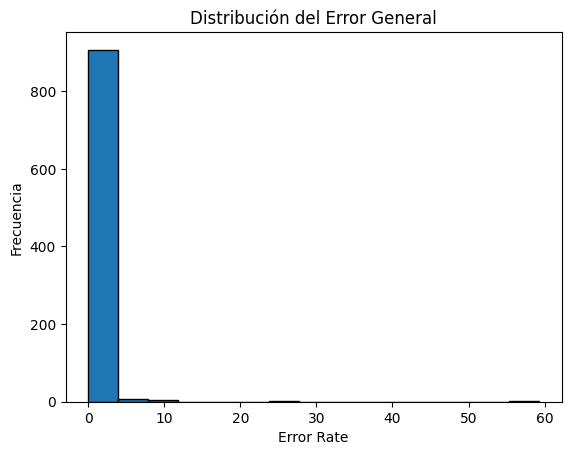

In [209]:
import matplotlib.pyplot as plt

# Asegúrate de que solo tomas los valores que no son NaN para el histograma
error_values = valid_abril['error'].dropna()

# Crea el histograma
plt.hist(error_values, bins=15, edgecolor='black')  # Puedes ajustar el número de bins según sea necesario

# Agrega títulos y etiquetas
plt.title('Distribución del Error General')
plt.xlabel('Error Rate')
plt.ylabel('Frecuencia')

# Muestra el histograma
plt.show()


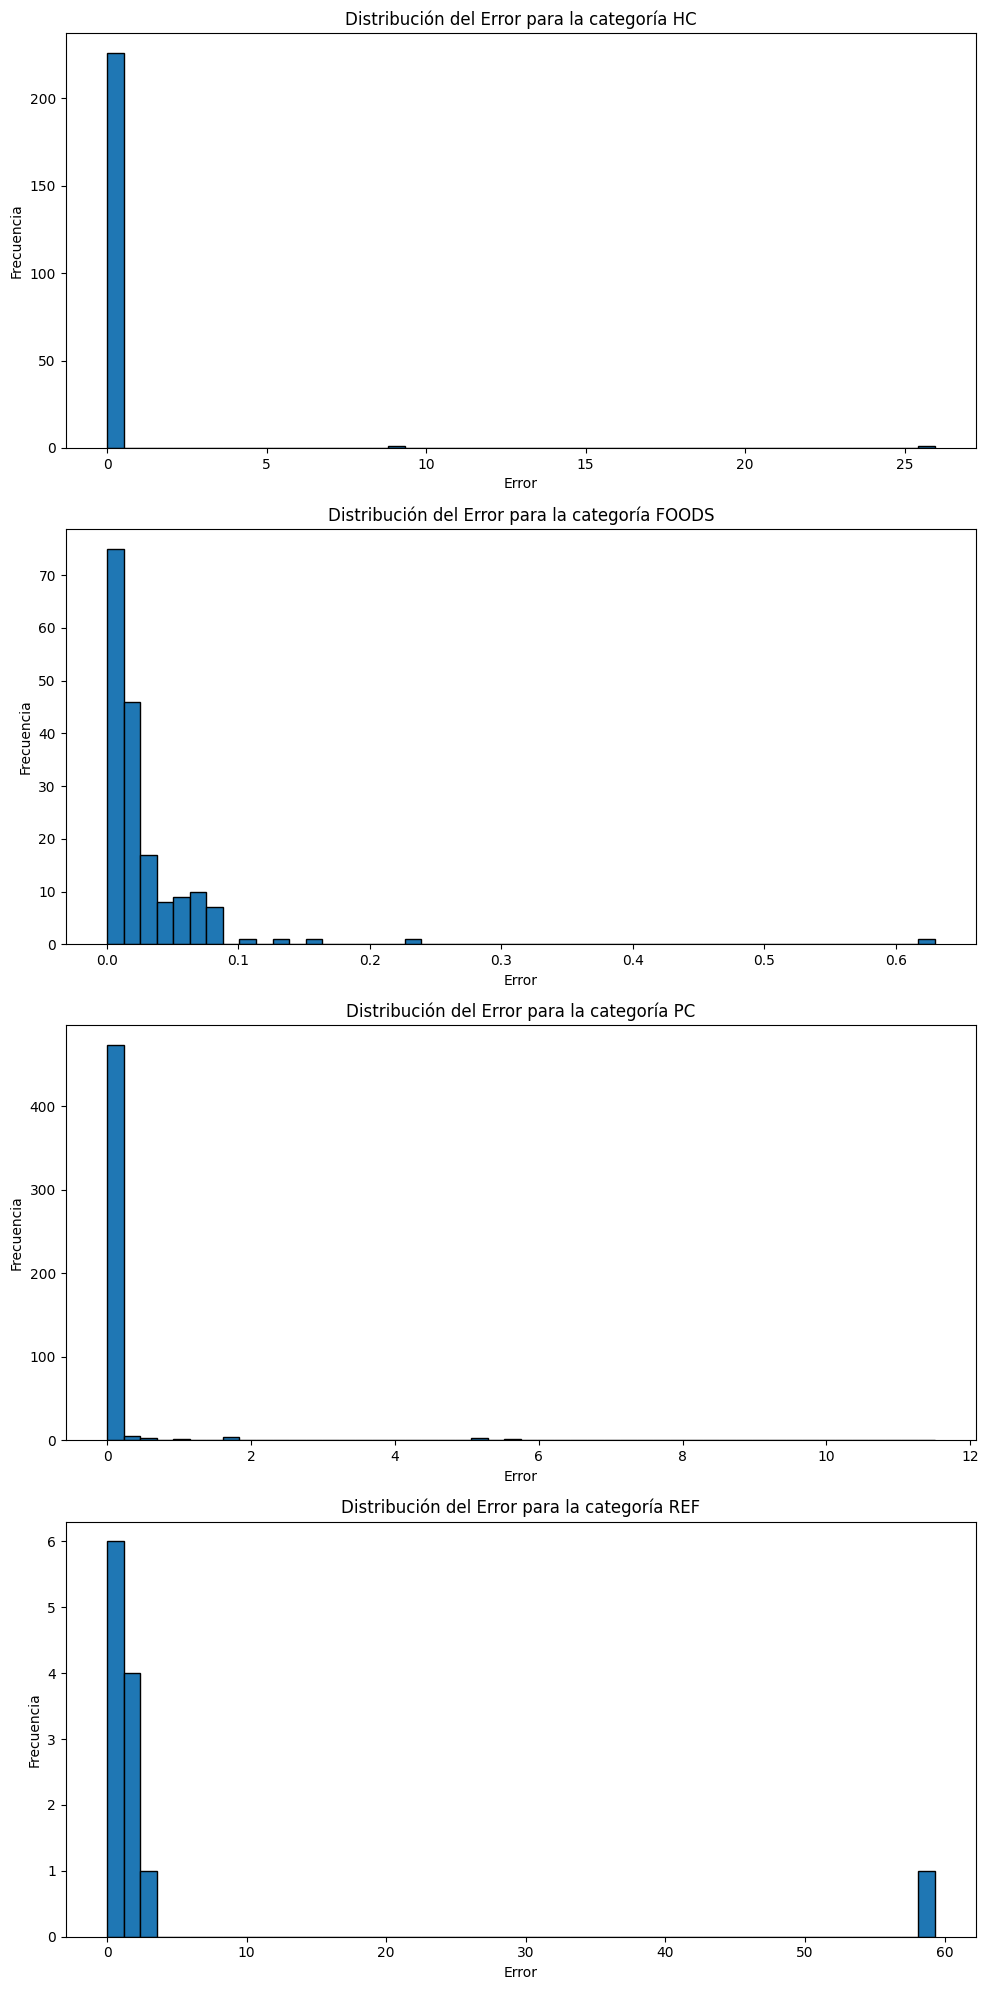

In [210]:
# Asegúrate de que 'cat1' es el nombre de tu columna de categorías en el DataFrame
unique_categories = valid_abril['cat1'].unique()

# Crea una figura y un conjunto de subgráficos
fig, axes = plt.subplots(nrows=len(unique_categories), ncols=1, figsize=(10, 5 * len(unique_categories)))

# Si solo hay una categoría, axes no será un array, así que lo convertimos en uno para poder iterar
if len(unique_categories) == 1:
    axes = [axes]

# Itera sobre todas las categorías únicas y crea un histograma para cada una
for ax, category in zip(axes, unique_categories):
    # Filtra el DataFrame por la categoría actual y elimina los valores NaN
    category_errors = valid_abril[valid_abril['cat1'] == category]['error'].dropna()
    
    # Crea el histograma para la categoría actual
    ax.hist(category_errors, bins=50, edgecolor='black')
    
    # Agrega títulos y etiquetas
    ax.set_title(f'Distribución del Error para la categoría {category}')
    ax.set_xlabel('Error')
    ax.set_ylabel('Frecuencia')

# Ajusta el layout para evitar la superposición
plt.tight_layout()
# Muestra el histograma
plt.show()


In [71]:
# Suponiendo que 'valid_abril' es tu DataFrame y que 'y_pred_abril' es la serie de predicciones:
valid_abril['y_pred_abril'] = y_pred_abril

# Obtiene las categorías únicas de 'cat1'
unique_categories = valid_abril['cat1'].unique()

# Diccionario para almacenar los errores de cada categoría
category_errors = {}

# Recorre todas las categorías únicas
for category in unique_categories:
    # Filtra las filas para la categoría actual
    categoria_abril = valid_abril[valid_abril['cat1'] == category]
    
    # Asegúrate de que hay datos para calcular el error
    if not categoria_abril.empty and categoria_abril['tn'].sum() != 0:
        # Calcula el error para la categoría actual
        error = calculate_error(list(categoria_abril['y_pred_abril']), list(categoria_abril['tn']))
        
        # Almacena el error en el diccionario usando la categoría como clave
        category_errors[category] = error
        
        # Imprime el error para la categoría actual
        print(f'The error for category {category} is: {error}')
    else:
        # Maneja el caso donde no hay datos o la suma de 'tn' es cero
        category_errors[category] = None
        print(f'Cannot calculate error for category {category} due to insufficient data or sum of tn is zero.')

The error for category HC is: 0.06071351486228264
The error for category FOODS is: 0.0328074956419881
The error for category PC is: 0.01725002522140297
The error for category REF is: 0.19637741945404286


C:\Users\Lean\AppData\Local\Temp\ipykernel_8564\3435764702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_abril['y_pred_abril'] = y_pred_abril
